In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [2]:
# Load datasets
train_data = pd.read_csv('loan-train.csv')  # Replace with your training file path
test_data = pd.read_csv('loan-test.csv')    # Replace with your test file path

In [3]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
print(train_data.shape)

(614, 13)


In [5]:
train_data.Loan_ID.value_counts(dropna=False)

,count
Loan_ID,
LP001002,1
LP002328,1
LP002305,1
LP002308,1
LP002314,1
...,...
LP001692,1
LP001693,1
LP001698,1


In [6]:
train_data.Loan_Status.value_counts(dropna=False)

,count
Loan_Status,
Y,422
N,192


<ipython-input-7-cfe5bdfae0f5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Loan_Status', data=train_data, palette='viridis')


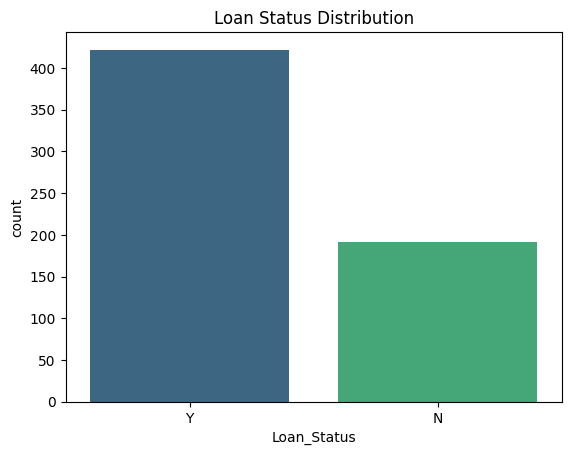

In [7]:
# Visualization 1: Loan Status Distribution
sns.countplot(x='Loan_Status', data=train_data, palette='viridis')
plt.title('Loan Status Distribution')
plt.show()

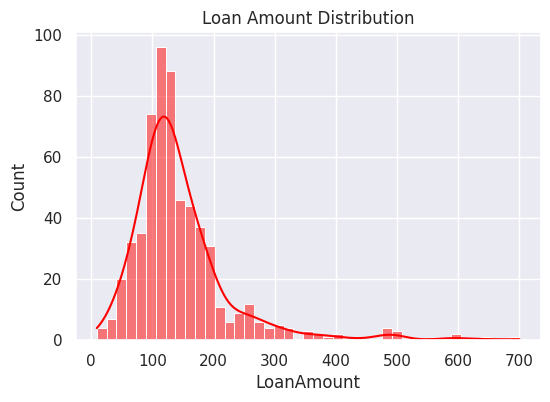

In [8]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(6, 4))

plt.title('Loan Amount Distribution')

sns.histplot(data=train_data, x="LoanAmount", kde=True, ax=ax, color='red');

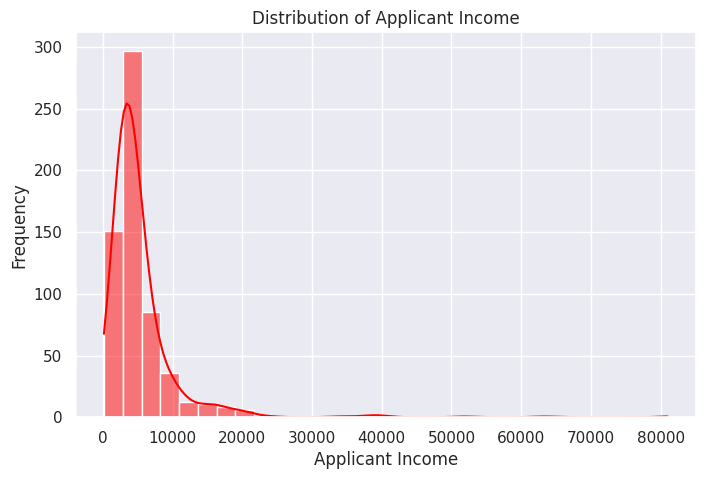

In [9]:
# Visualization 1: Distribution of ApplicantIncome
plt.figure(figsize=(8, 5))
sns.histplot(train_data['ApplicantIncome'], bins=30, kde=True, color='red')
plt.title('Distribution of Applicant Income')
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show()


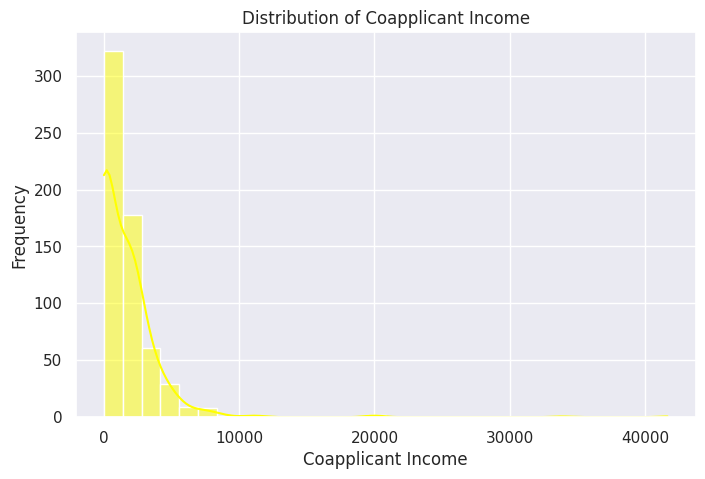

In [10]:
# Visualization 1: Distribution of ApplicantIncome
plt.figure(figsize=(8, 5))
sns.histplot(train_data['CoapplicantIncome'], bins=30, kde=True, color='yellow')
plt.title('Distribution of Coapplicant Income')
plt.xlabel('Coapplicant Income')
plt.ylabel('Frequency')
plt.show()

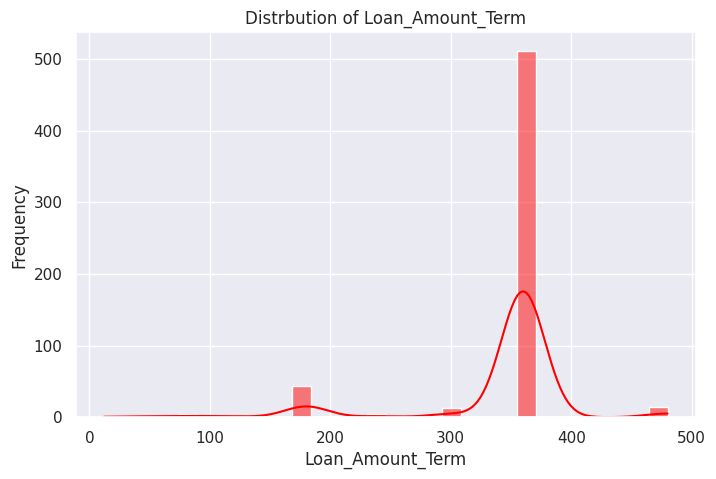

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(train_data['Loan_Amount_Term'], bins=30, kde=True, color='red')
plt.title('Distrbution of Loan_Amount_Term')
plt.xlabel('Loan_Amount_Term')
plt.ylabel('Frequency')
plt.show()


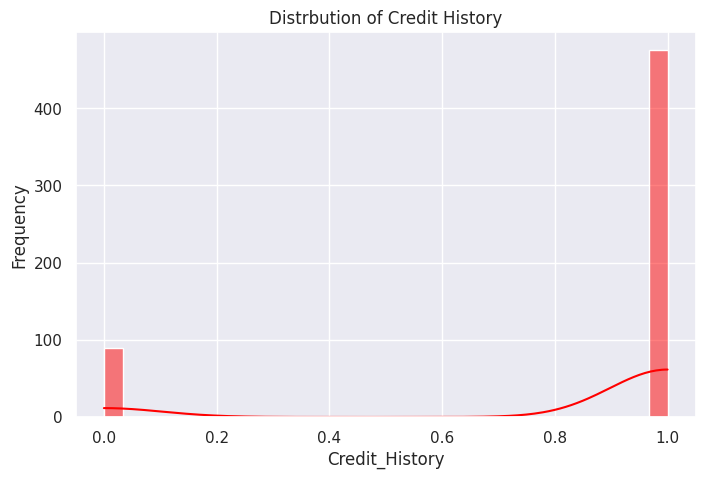

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(train_data['Credit_History'], bins=30, kde=True, color='red')
plt.title('Distrbution of Credit History')
plt.xlabel('Credit_History')
plt.ylabel('Frequency')
plt.show()


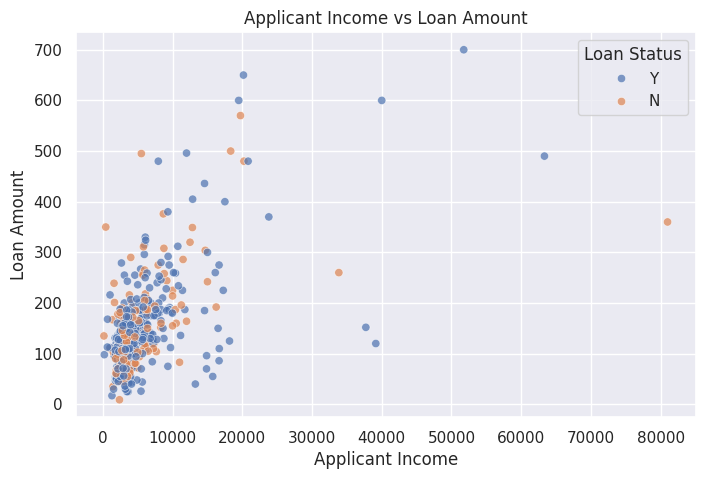

In [13]:
# Scatter plot visualization of ApplicantIncome vs LoanAmount
plt.figure(figsize=(8, 5))
sns.scatterplot(data=train_data, x='ApplicantIncome', y='LoanAmount', hue='Loan_Status', alpha=0.7)
plt.title('Applicant Income vs Loan Amount')
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.legend(title='Loan Status')
plt.show()

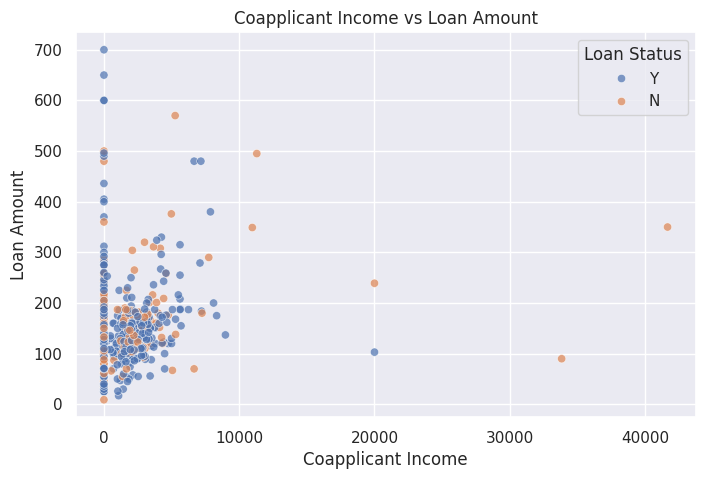

In [14]:
# Visualization 7: Scatter plot of CoapplicantIncome vs LoanAmount
plt.figure(figsize=(8, 5))
sns.scatterplot(data=train_data, x='CoapplicantIncome', y='LoanAmount', hue='Loan_Status', alpha=0.7)
plt.title('Coapplicant Income vs Loan Amount')
plt.xlabel('Coapplicant Income')
plt.ylabel('Loan Amount')
plt.legend(title='Loan Status')
plt.show()

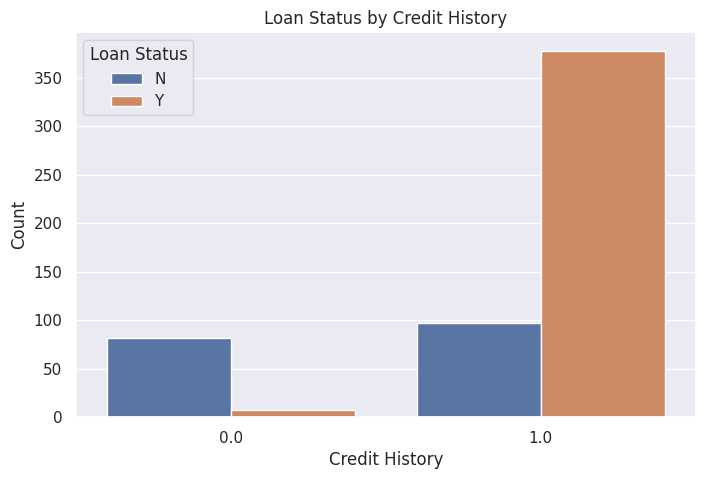

In [15]:
# Visualization 8: Countplot of Credit History vs Loan_Status
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='Credit_History', hue='Loan_Status')
plt.title('Loan Status by Credit History')
plt.xlabel('Credit History')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

In [16]:
train_data.isnull().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


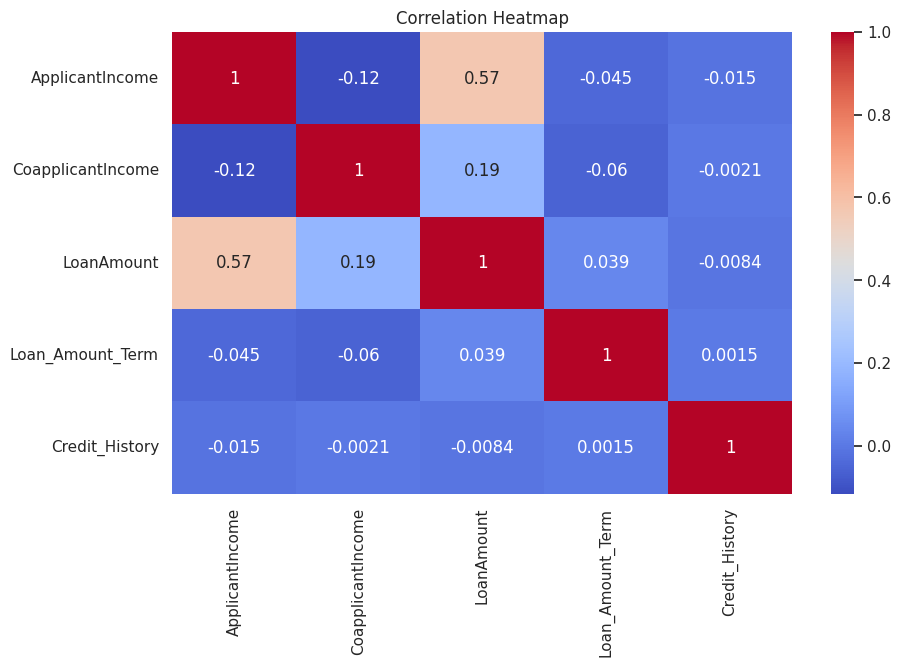

In [17]:
# Visualization : Correlation Heatmap (numeric columns only)
numeric_cols = train_data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [18]:
# Function to preprocess data
def preprocess_data(data, is_training=True):
    data.fillna({
        'Gender': 'Male',
        'Married': 'No',
        'Dependents': '0',
        'Self_Employed': 'No',
        'LoanAmount': data['LoanAmount'].median(),
        'Loan_Amount_Term': data['Loan_Amount_Term'].median(),
        'Credit_History': data['Credit_History'].mode()[0]
    }, inplace=True)

    data['Dependents'] = data['Dependents'].replace('3+', 3).astype(int)

    label_encoders = {}
    for col in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

    if is_training and 'Loan_Status' in data.columns:
        data['Loan_Status'] = data['Loan_Status'].map({'Y': 1, 'N': 0})

    return data, label_encoders

In [19]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [20]:
# Preprocess data
train_data_preprocessed, label_encoders = preprocess_data(train_data, is_training=True)
test_data_preprocessed, _ = preprocess_data(test_data, is_training=False)

In [21]:
# Prepare training data
X = train_data_preprocessed.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = train_data_preprocessed['Loan_Status']

In [22]:
X, y = SMOTE().fit_resample(X, y)

In [23]:
# Split the training dataset for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500)
}

In [25]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    results[name] = accuracy

    print(f"{name} Model")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_valid, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
    print("-" * 50)

Random Forest Model
Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.80        94
           1       0.73      0.85      0.79        75

    accuracy                           0.79       169
   macro avg       0.80      0.80      0.79       169
weighted avg       0.80      0.79      0.79       169

Confusion Matrix:
 [[70 24]
 [11 64]]
--------------------------------------------------
Decision Tree Model
Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77        94
           1       0.70      0.80      0.75        75

    accuracy                           0.76       169
   macro avg       0.76      0.76      0.76       169
weighted avg       0.77      0.76      0.76       169

Confusion Matrix:
 [[68 26]
 [15 60]]
--------------------------------------------------
Logistic Regression Model
Accuracy: 0.72
Classific

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<ipython-input-26-a3279c8c2b0a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='plasma')


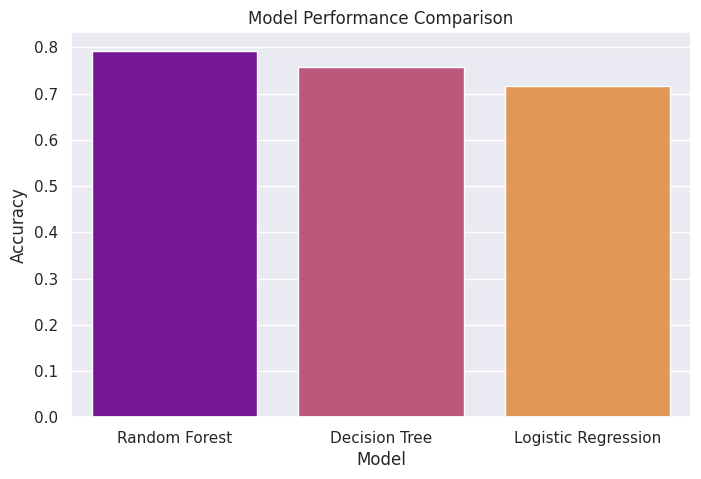

In [26]:
# Visualize model performance
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='plasma')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

In [27]:
# Select the best model (Random Forest, in this case)
final_model = models['Random Forest']
final_model.fit(X, y)

RandomForestClassifier(random_state=42)

In [29]:
# Prepare test data for prediction
X_test = test_data_preprocessed.drop(['Loan_ID'], axis=1)
predictions = final_model.predict(X_test)

In [30]:
# Add predictions to the test dataset
test_data_preprocessed['Loan_Status'] = predictions
test_data_preprocessed['Loan_Status'] = test_data_preprocessed['Loan_Status'].map({1: 'Y', 0: 'N'})

In [31]:
# Save the predictions to a CSV file
output_file_path = 'loan-test-predictions.csv'
test_data_preprocessed[['Loan_ID', 'Loan_Status']].to_csv(output_file_path, index=False)

In [32]:
print(f"Predictions saved to {output_file_path}.")

Predictions saved to loan-test-predictions.csv.
